# Respiratory sound database

Основная часть нашего датасета - 920 аудиофайлов, на которых записано дыхание человека. Люди были подобраны из разных возрастных групп, разного пола, веса и тд. Для записи использовалось 4 устройства: обычный микрофон и 3 стетоскопа разного качества. Для каждого человека была диагностирована болезнь (связанная с бронхами, легкими) или же отсутствие таковой. 

Также, каждый аудиофайл был разбит на сегменты различной длины, для каждого помечалось, слышны ли на записи грудные хрипы, одышка, или же дыхание было "чистым".

## Поставим задачу машинного обучения
#### Общая:
Определить наличие или отстутствие заболевания и классифицировать его. В качестве целевой переменной использовать тип болезни.

#### Промежуточная:
Научить модель распознавать хрип и одышку на записанных аудиофайлах. В качестве целевой переменной использовать наличие затрудненного дыхания.

В качестве тренировочных данных использовать аудиофайлы, перекодированные в числовые признаки. 

In [1]:
#импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import random

from glob import glob
import os

from tqdm.notebook import tqdm
import itertools

#from skimage.color import gray2rgb
import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import models,layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

from focal_loss import categorical_focal_loss #imported loss got from open source

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

#custom functions in 'functions.py'
from functions import create_df_files_analyze, create_df_audio_analyze, create_label, plot_spectogram, slice_data

sr=22050

Using TensorFlow backend.


# Необходимые функции

Считаем названия наших аудиофайлов. Нужно заметить, что сортировки по id в audio_files нет.

In [2]:
path = "Respiratory_sound_Database/"
audio_path = "Respiratory_sound_Database/audio_and_txt_files/"
audio_files = glob(audio_path +'/*.wav')
audio_files = [file for file in audio_files if file.find('AKG') == -1]
print('{} wav format files.'.format(len(audio_files)))
print()
print('First 3 files: ')
for i in range(3):
    print(audio_files[i])

274 wav format files.

First 3 files: 
Respiratory_sound_Database/audio_and_txt_files/120_1b1_Ar_sc_Meditron.wav
Respiratory_sound_Database/audio_and_txt_files/167_1b1_Pr_sc_Meditron.wav
Respiratory_sound_Database/audio_and_txt_files/134_2b1_Ar_mc_LittC2SE.wav


Важный момент, на который хочется обратить внимание. Было решено не использовать в начальной модели аудиофайлы, записанные на обычный микрофон. Микрофонные записи содержат много помех, и скармливать нашей модели сразу же "грязные" данные было бы неправильно. Вторая причина - банальное снижение используемой памяти, чтобы Jupiter меньше вылетал (такое частенько было на этапе компилирования).

Информация о диагнозе пациента лежит в файле 'patient_diagnosis.csv'.

In [3]:
label = pd.read_csv(path + 'patient_diagnosis.csv',names=['diagnosis'])
label.diagnosis.unique()

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

 Всего наш датасет имеет 8 возможных диагнозов. Перекодируем тип object в числовой признак.

In [4]:
le = LabelEncoder()
audio_labels = [label.loc[int(file[47:50]),'diagnosis'] for file in audio_files] #считываем по ID пациента
y = le.fit_transform(audio_labels).astype('uint8')
print(y[101], ' corresponds to ', label.loc[int(audio_files[101][47:50]),'diagnosis'])
print(y[100], ' corresponds to ', label.loc[int(audio_files[100][47:50]),'diagnosis'])

5  corresponds to  LRTI
3  corresponds to  COPD


Интересно было бы взглянуть на распределение целевой переменной. Посчитаем количество каждого диагноза среди пациентов и среди соответствующих им аудиозаписей.

In [5]:
values_files,counts_files = np.unique(audio_labels, return_counts=True)
values_ID,counts_ID = np.unique(label.diagnosis.values, return_counts=True)

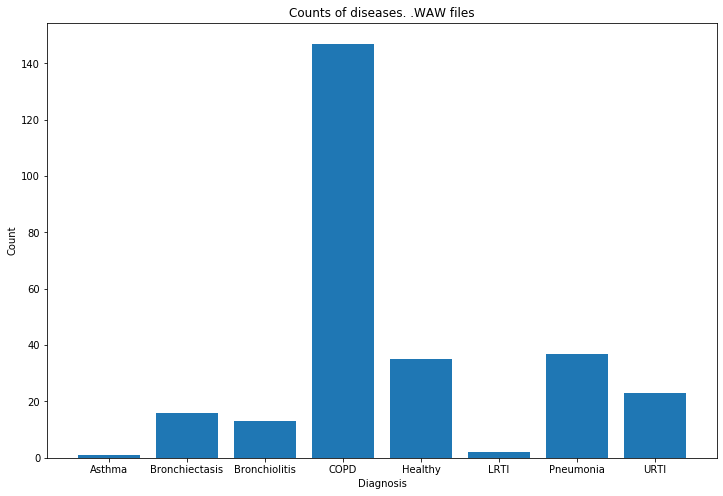

In [6]:
plt.figure(figsize=(12,8))
plt.bar(values_files,counts_files)
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Counts of diseases. .WAW files')
plt.show()

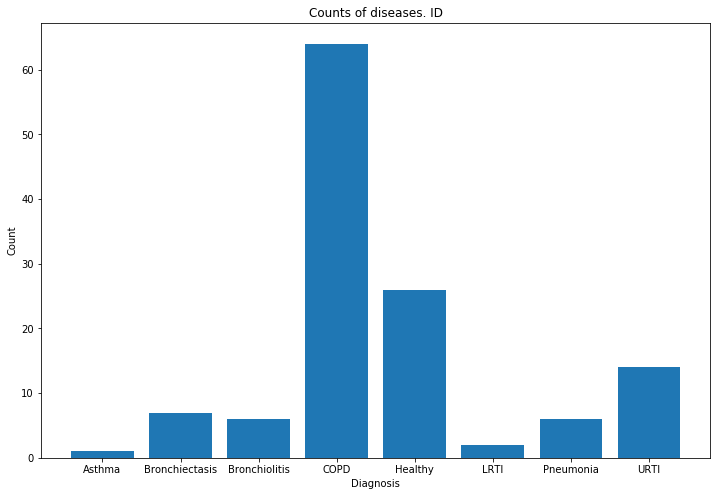

In [7]:
plt.figure(figsize=(12,8))
plt.bar(values_ID,counts_ID)
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Counts of diseases. ID')
plt.show()

По графикам видно явное преобладание диагноза COPD над другими (Хроническая обструктивная болезнь легких). Это говорит нам о несбалансированности классов, всегда нужно держать в голове этот факт и подбирать соответсвующие метрики, возможно воспользоваться аугментацией данных (оверсемплингом). 

Как бы нам не хотелось помочь астматикам, но в нашем датасете лишь один такой больной, он никак не повлияет на нашу модель обучения, но и ждать от нее каких-то точных результатов в плане определения астмы (или инфекции нижних дыхательных путей - LRTI, двое больных) не стоит. 

Создадим два датафрейма. Первый дает полезную информацию об аудиофайле(идентификатор пациента, устройство для записи, область грудной клетки и тд). Второй датафрейм содержит информацию о сегментах: начало и конец интервала, наличие хрипов и одышки.

In [8]:
df_files = create_df_files_analyze(audio_files,audio_labels)
df_audio = create_df_audio_analyze(audio_files,audio_labels)

In [9]:
print(df_files.shape)
df_files.head()

(274, 16)


,ID,time,Tc,Al,Ar,Pl,Pr,Ll,Lr,AKGC417L,LittC2SE,Litt3200,Meditron,sc,mc,diagnosis
101_1b1_Al_sc_Meditron,101,NaN,0,1,0,0,0,0,0,0,0,0,1,1,0,URTI
101_1b1_Pr_sc_Meditron,101,NaN,0,0,0,0,1,0,0,0,0,0,1,1,0,URTI
102_1b1_Ar_sc_Meditron,102,NaN,0,0,1,0,0,0,0,0,0,0,1,1,0,Healthy
103_2b2_Ar_mc_LittC2SE,103,NaN,0,0,1,0,0,0,0,0,1,0,0,0,1,Asthma
104_1b1_Pl_sc_Litt3200,104,NaN,0,0,0,1,0,0,0,0,0,1,0,1,0,COPD


In [10]:
print(df_audio.shape)
df_audio.head()

(2552, 5)


,start,end,crackles,wheezes,file
120_1b1_Ar_sc_Meditron,0.80746,3.4236,0,0,120_1b1_Ar_sc_Meditron
120_1b1_Ar_sc_Meditron,3.42360,5.9752,0,0,120_1b1_Ar_sc_Meditron
120_1b1_Ar_sc_Meditron,5.97520,8.4837,0,0,120_1b1_Ar_sc_Meditron
120_1b1_Ar_sc_Meditron,8.48370,11.4440,0,0,120_1b1_Ar_sc_Meditron
120_1b1_Ar_sc_Meditron,11.44400,14.1040,0,0,120_1b1_Ar_sc_Meditron


В следующей ячейке считывается каждый аудиофайл функцией librosa.load, затем этот аудиофайл разбивается на части и передается в список parts в виде массива со значениями float.

In [11]:
#parts = []
#count = 0

#sr = 22050

#for file in tqdm(audio_files):
    #filename = file[47:]
    #audio, sfreq = librosa.load(file,sr=sr)
    #seconds = np.linspace(0,len(audio)/sfreq,len(audio))
    #df_now = df_audio[df_audio.file == filename[:-4]]
    #seconds_copy = seconds.copy()
    #for i in range(df_now.shape[0]):
        #start = df_now.iloc[i,0]
        #end = df_now.iloc[i,1]
        #c = np.argmax(seconds_copy > start+0.0001)
        #d = np.argmin(seconds_copy <= end-0.0001)
        ##print(c,d,i,count)
        #part = audio[c:d]
        #parts.append(part)
        #count += 1
        
parts = np.load('parts_22050_no_AKGC.npy',allow_pickle=True)
#np.save('parts_{}_no_AKGC.npy'.format(sr),parts)

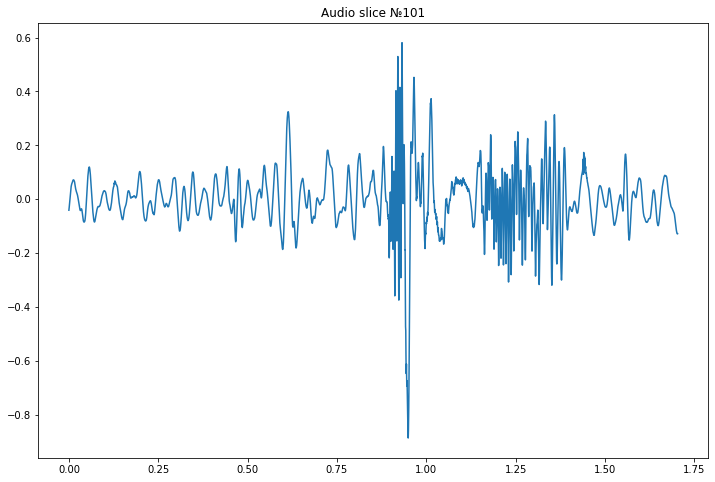

In [12]:
n = 101
plt.figure(figsize=(12,8))
plt.title('Audio slice №{}'.format(n))
plt.plot(np.linspace(0,len(parts[n])/sr,len(parts[n])),parts[n])
plt.show()

Такие графики на вид интересны, но информативной пользы для модели не несут. Всякий аудиосигнал разлагается на частоты и амплитуды с помощью преобразования Фурье и его разновидностей. Нами будет использовано Constant-Q преобразование (CQT). Избегая лишней математики - это смесь преобразования Фурье и вейвлет-преобразования. CQT подходит для низкочастотных аудиосигналов, а его разновидность "pseudo-CQT" охватывает верхнечастотный диапазон. Преобразование "hybrid-CQT", реализованная в библиотеке librosa, сочетает в себе оба этих метода. Это позволит нам максимально эффективно преобразовывать аудиофайлы.

In [13]:
#cqt_data = []
#for i in tqdm(range(len(parts))):
    #C = librosa.hybrid_cqt(parts[i],n_bins=101,sr=sr)
    #C = librosa.util.pad_center(C,697)
    #C = librosa.amplitude_to_db(C, ref=np.max)
    #C /= (np.max(np.abs(C))+0.0001)
    #C *= 255
    #C = C.astype(np.uint8)
    #print(C.min())
    #cqt_data.append(C)

cqt_data = np.load('data/cqt_data_22050_hybrid_no_AKGC.npy')
cqt_data = (cqt_data/255).astype(np.float32)
#np.save('data/cqt_data_{}_hybrid_no_AKGC.npy'.format(sr),cqt_data)

In [14]:
cqt_data = np.vstack(cqt_data).reshape((len(parts),101,697,1))

Все представления аудиосегментов должны быть сведены к одному размеру. Наша преобразованная дата содержится в тензоре cqt_data размера (6898,101,697,1). Единица означает один единственный фильтр "изображения" аудисигнала. 101 - параметр n_bins функции librosa.hybrid_cqt. Размер 697 вычислен из размера самого длинного сегмента. Все "изображения" центрированы, а самый длинный из всех сегментов займет всю площадь (101,697). 

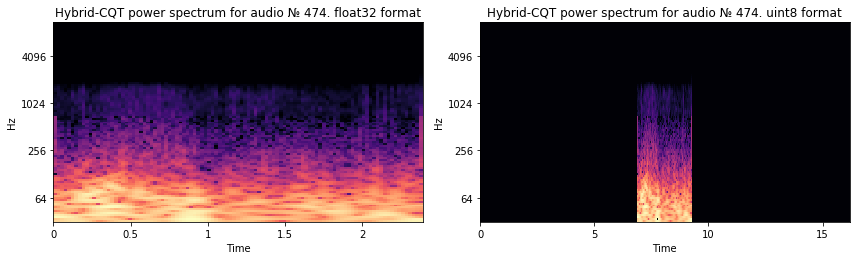

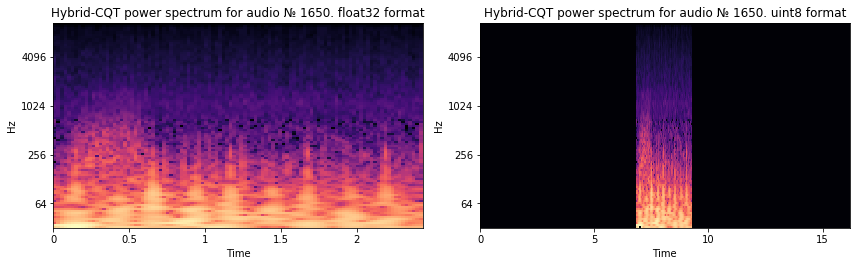

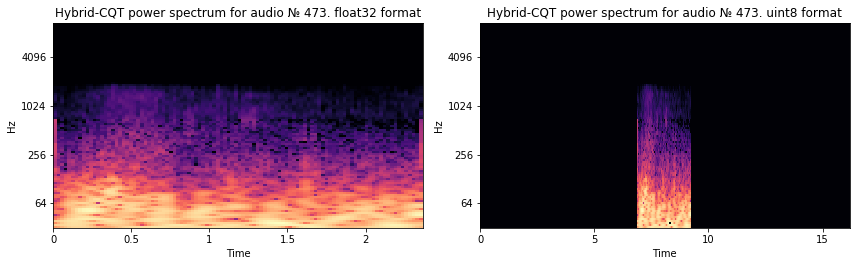

In [15]:
count = 1
for i in np.random.randint(0,len(parts),3):
    #print(i)
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(3, 2, count)
    ax = plot_spectogram(parts,cqt_data,i,False,sr)
    ax = fig.add_subplot(3, 2, count+1)
    ax = plot_spectogram(parts,cqt_data,i,True,sr)
    count+=2
plt.show()

In [16]:
#cqt_label = create_label()

In [17]:
#cqt_label.shape

Далее подготовим наш целевой вектор.

In [18]:
a = df_audio.crackles.map(lambda x: 0.5 if x == 1 else 0)
b = df_audio.wheezes
labels_cw = (a+b).map(lambda x: 0 if x == 0 else (1 if x == 0.5 else (2 if x == 1 else 3))).values
#labels_cw = labels_cw.astype(np.bool)
#labels_cw = labels_cw.astype(np.uint8)

Распределение количества хрипов и одышек на нижнем графике. Как и в случае с диагностированием заболевания, задача определения нарушений дыхания также содержит несбалансированную выборку.

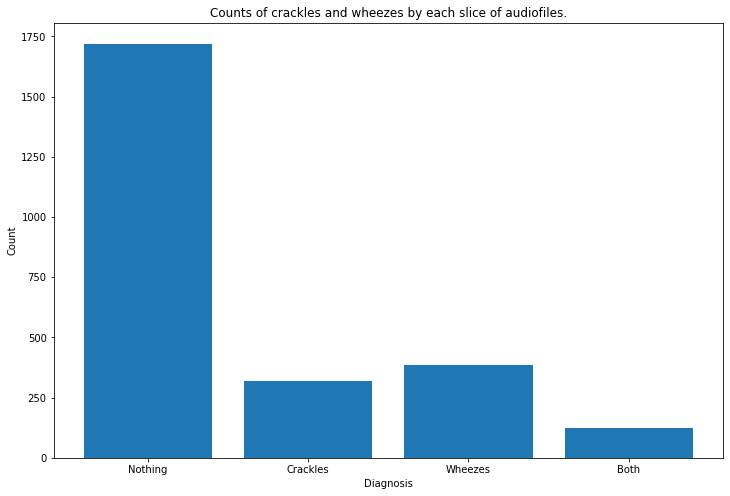

In [19]:
values_cw, counts_cw = np.unique(labels_cw,return_counts=True)
plt.figure(figsize=(12,8))
plt.bar(['Nothing', 'Crackles', 'Wheezes', 'Both'],counts_cw)
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Counts of crackles and wheezes by each slice of audiofiles.')
plt.show()

In [20]:
#cqt_data_rgb = gray2rgb(cqt_data).reshape((2552,101,697,3))
#cqt_data_rgb.shape
#cqt_label = cqt_label.astype(np.float32)
#labels_cw = labels_cw.astype(np.float32)

In [21]:
labels_cw_old = labels_cw.copy()

Откинем сегменты, в которых присутствует и хрип и одышка, так как это уже задача с пересекающимися классами, требующая отдельных подоходов. Откинется всего 125 сэмплов, что совсем не критично.

In [22]:
index_need = np.nonzero(labels_cw_old != 3)[0]
cqt_data_new = cqt_data[index_need,:,:,:]
cqt_data_new.shape

(2427, 101, 697, 1)

In [23]:
labels_cw = tf.keras.utils.to_categorical(labels_cw_old[index_need]).astype(np.float32)

In [25]:
#train_test_split используем со стратификацией и shuffle=True
x_train, x_test, y_train, y_test = train_test_split(cqt_data_new, labels_cw, 
                                                    stratify=labels_cw, 
                                                    test_size=0.3, random_state = 42,shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, 
                                                    test_size=0.2, random_state = 42,shuffle=True)


В качестве модели обучения и предсказывания будем использовать сверточную нейросеть, с четырьмя сверточными слоями и слоем MaxPooling после каждого. Это начальная модель, которая на первых порах сможет нам подсказать, в каком направлении двигаться дальше.

In [33]:
K.clear_session()

model = Sequential()
model.add(layers.Conv2D(32, (2, 2),padding='same', activation='relu',input_shape=(101, 697, 1)))
model.add(layers.MaxPool2D(pool_size=(2, 2),data_format='channels_last'))
model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2),data_format='channels_last'))
model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2),data_format='channels_last'))
model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2),data_format='channels_last'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 101, 697, 32)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 348, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 348, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 174, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 174, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 87, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 87, 128)       1

In [34]:
callbacks_list = [EarlyStopping(monitor='val_loss',patience=3),
                  ModelCheckpoint(filepath='my_model_hybrid.h5',monitor='val_accuracy',save_best_only=True)
                ]

##### ВАЖНО
В качестве функции потерь будем использовать Focal loss function, которая предназначена для классификации классов с несбалансированным распределением. Мерой качества будет являться accuracy score.

In [35]:
model.compile(loss=categorical_focal_loss(alpha=0.25),optimizer=optimizers.Adam(),metrics=['accuracy'])

In [36]:
history = model.fit(x_train,y_train,epochs=50,batch_size=64,validation_data = (x_val,y_val),
                   callbacks=callbacks_list,#class_weight=class_weights
                   )

Train on 1358 samples, validate on 340 samples
Epoch 1/50
1358/1358 [==============================] - 13s 10ms/sample - loss: 0.0290 - accuracy: 0.6996 - val_loss: 0.0291 - val_accuracy: 0.7088
Epoch 2/50
1358/1358 [==============================] - 12s 9ms/sample - loss: 0.0278 - accuracy: 0.7062 - val_loss: 0.0278 - val_accuracy: 0.7088
Epoch 3/50
1358/1358 [==============================] - 12s 9ms/sample - loss: 0.0268 - accuracy: 0.7091 - val_loss: 0.0289 - val_accuracy: 0.6618
Epoch 4/50
1358/1358 [==============================] - 12s 9ms/sample - loss: 0.0258 - accuracy: 0.7106 - val_loss: 0.0259 - val_accuracy: 0.7059
Epoch 5/50
1358/1358 [==============================] - 12s 9ms/sample - loss: 0.0244 - accuracy: 0.7069 - val_loss: 0.0271 - val_accuracy: 0.7000
Epoch 6/50
1358/1358 [==============================] - 13s 9ms/sample - loss: 0.0239 - accuracy: 0.7150 - val_loss: 0.0254 - val_accuracy: 0.7118
Epoch 7/50
1358/1358 [==============================] - 12s 9ms/sample

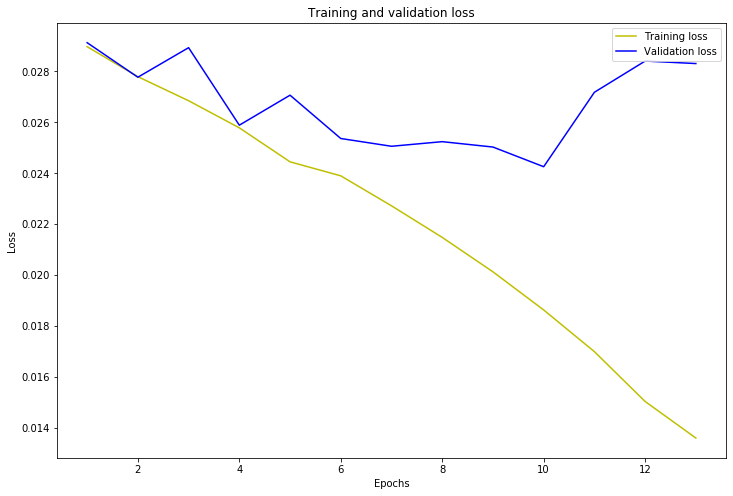

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

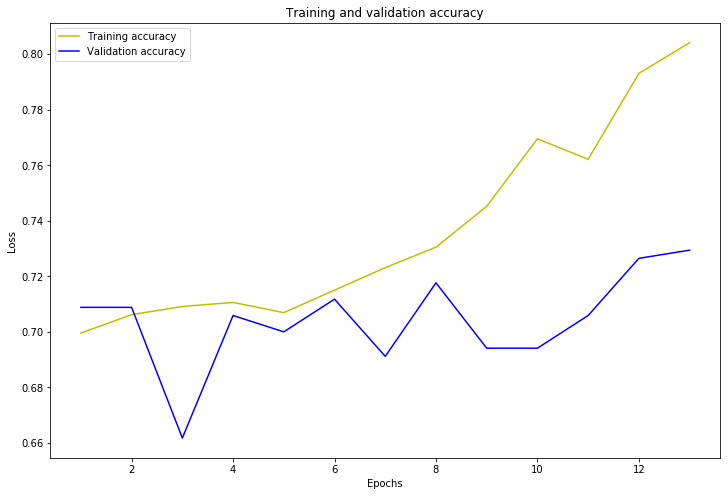

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Значения loss_func и accuracy на тестовой выборке:

In [39]:
model.evaluate(x_test,y_test,batch_size=32)

729/729 [==============================] - 2s 3ms/sample - loss: 0.0268 - accuracy: 0.7435


[0.02683090668718429, 0.7434842]

In [41]:
pred_test = model.predict_classes(x_test,batch_size=32)
print('Predicted [100:200]: \n', pred_test[100:200])
print('\n\nTrue [100:200]: \n',y_test[100:200].astype(np.int32))


Predicted [100:200]: 
 [0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 2 1 0 0 1 0 0 0 2 1 0 0 0 2 0 0 0 0 0 0 0
 0 0 1 0 0 0 2 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]


True [100:200]: 
 [[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 

##### Важно
Можно сказать, что focal loss действительно справляется с переобучением на наиболее встречаемый класс. Здесь этого не показано, но результатом нейроной сети с фукнцией потерь categorical cross-entropy были все нули (Nothing), и точность соответственно была выше, но в этом и ловушка задач с несбалансированной выборкой. Focal loss function этого не допускает.



...

Есть ощущение, что наша дата интерпретирована не совсем корректно. Действительно, глядя на спектограммы, нужно воспринимать это как векторные слои для определенного участка частот. Грубо говоря, нам важно не только найти какую-то похожую интерпретацию определенного звука, важно еще определить ее на нужной частоте. 

Звучит вроде разумно. Работает ли это на практике? Разобьем наши спектограмы на три части (низкие, средние и высокие частоты). И обучим ту же самую нейронную сеть на выборке, которая теперь имеет 3 фильтра (не путать с RGB-фильтрами).

In [24]:
n=3
cqt_data_sliced = []
for C in cqt_data_new:
    sliced_C = slice_data(C,n)
    cqt_data_sliced.append(sliced_C)
cqt_data_sliced = np.vstack(cqt_data_sliced).reshape((2427,round(100/n),697,n))
cqt_data_sliced.shape

(2427, 33, 697, 3)

In [25]:
index = 101
for i in range(n):
    print('{}th slice is simillar to {}th filter: '.format(i+1,i+1), 
          np.array_equal(cqt_data_sliced[index,:,:,i],cqt_data_new[index,i*round(100/n):round(100/n)*(i+1),:,0]))

1th slice is simillar to 1th filter:  True
2th slice is simillar to 2th filter:  True
3th slice is simillar to 3th filter:  True


In [28]:
#train_test_split используем со стратификацией и shuffle=True
x_train, x_test, y_train, y_test = train_test_split(cqt_data_sliced, labels_cw, stratify=labels_cw, 
                                                    test_size=0.3, random_state = 42,shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, 
                                                    test_size=0.2, random_state = 42,shuffle=True)


In [45]:
K.clear_session()

model = Sequential()
model.add(layers.Conv2D(32, (2, 2),padding='same', activation='relu',input_shape=(33, 697, 3)))
model.add(layers.MaxPool2D(pool_size=(2, 2),data_format='channels_last'))
model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2),data_format='channels_last'))
model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2),data_format='channels_last'))
model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2),data_format='channels_last'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 697, 32)       416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 348, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 348, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 174, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 174, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 87, 128)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 87, 128)        1

In [48]:
callbacks_list = [EarlyStopping(monitor='val_loss',patience=3),
                  ModelCheckpoint(filepath='my_model_hybrid_sliced.h5',monitor='val_accuracy',save_best_only=True)
                ]


In [49]:
model.compile(loss=[categorical_focal_loss(alpha=0.25)],
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [50]:
history = model.fit(x_train,y_train,epochs=50,batch_size=64,validation_data = (x_val,y_val),
                   callbacks=callbacks_list,#class_weight=class_weights
                   )

Train on 1358 samples, validate on 340 samples
Epoch 1/50
1358/1358 [==============================] - 8s 6ms/sample - loss: 0.0292 - accuracy: 0.7040 - val_loss: 0.0281 - val_accuracy: 0.7088
Epoch 2/50
1358/1358 [==============================] - 4s 3ms/sample - loss: 0.0277 - accuracy: 0.7084 - val_loss: 0.0300 - val_accuracy: 0.7088
Epoch 3/50
1358/1358 [==============================] - 4s 3ms/sample - loss: 0.0273 - accuracy: 0.7084 - val_loss: 0.0281 - val_accuracy: 0.7088
Epoch 4/50
1358/1358 [==============================] - 4s 3ms/sample - loss: 0.0260 - accuracy: 0.7069 - val_loss: 0.0268 - val_accuracy: 0.7088
Epoch 5/50
1358/1358 [==============================] - 4s 3ms/sample - loss: 0.0252 - accuracy: 0.7121 - val_loss: 0.0246 - val_accuracy: 0.7176
Epoch 6/50
1358/1358 [==============================] - 4s 3ms/sample - loss: 0.0241 - accuracy: 0.7128 - val_loss: 0.0251 - val_accuracy: 0.7147
Epoch 7/50
1358/1358 [==============================] - 4s 3ms/sample - loss:

In [51]:
model.evaluate(x_test,y_test,batch_size=32)

729/729 [==============================] - 2s 2ms/sample - loss: 0.0285 - accuracy: 0.6982


[0.028517482258042192, 0.69821674]

In [41]:
pred_test = model.predict_classes(x_test,batch_size=32)
print('Predicted [100:200]: \n', pred_test[100:200])
print('\n\nTrue [100:200]: \n',y_test[100:200].astype(np.int32))

Predicted [100:200]: 
 [0 0 0 0 1 0 0 0 2 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 0 0 0 0 2 1 0 0 0 0 0 1 0 1 0 2 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 1 2 0 0 0 0 0 0 0 2 0]


True [100:200]: 
 [[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 

Как мы видим, результаты стали даже несколько хуже. На самом деле, если взглянуть внимательно, видно, что модель ведет себя точно также. Даже разбивая спектограмы на 5 частей, это не даст никакого эффекта. 

### Дополнительно

Попробуем использовать сверточную нейронную сеть VGG19, хорошо зарекоммендовавшую себя в анализе изображений. "Разморозим" у нее 4 последних слоя, и добавим сверху два полносвязных под нашу задачу. 

In [30]:
conv_base = VGG19(weights='imagenet',include_top=False,input_shape=(33, 697, 3))

conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

K.clear_session()

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 21, 512)        20024384  
_________________________________________________________________
flatten (Flatten)            (None, 10752)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1376384   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 21,401,155
Trainable params: 6,096,387
Non-trainable params: 15,304,768
_________________________________________________________________


In [31]:
callbacks_list = [EarlyStopping(monitor='val_loss',patience=6),
                  ModelCheckpoint(filepath='my_model_hybrid_vgg.h5',monitor='val_accuracy',save_best_only=True)
                ]
model.compile(loss=categorical_focal_loss(alpha=0.25),optimizer=optimizers.Adam(),metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs=50,batch_size=64,validation_data = (x_val,y_val),
                   callbacks=callbacks_list,
                   )

Train on 1358 samples, validate on 340 samples
Epoch 1/50
1358/1358 [==============================] - 18s 13ms/sample - loss: 0.0504 - accuracy: 0.6591 - val_loss: 0.0346 - val_accuracy: 0.7088
Epoch 2/50
1358/1358 [==============================] - 16s 12ms/sample - loss: 0.0299 - accuracy: 0.7084 - val_loss: 0.0288 - val_accuracy: 0.7088
Epoch 3/50
1358/1358 [==============================] - 16s 12ms/sample - loss: 0.0292 - accuracy: 0.7084 - val_loss: 0.0284 - val_accuracy: 0.7088
Epoch 4/50
1358/1358 [==============================] - 16s 12ms/sample - loss: 0.0278 - accuracy: 0.7054 - val_loss: 0.0288 - val_accuracy: 0.7088
Epoch 5/50
1358/1358 [==============================] - 16s 12ms/sample - loss: 0.0276 - accuracy: 0.7084 - val_loss: 0.0262 - val_accuracy: 0.7088
Epoch 6/50
1358/1358 [==============================] - 16s 12ms/sample - loss: 0.0273 - accuracy: 0.7084 - val_loss: 0.0308 - val_accuracy: 0.7088
Epoch 7/50
1358/1358 [==============================] - 16s 12ms/

In [32]:
model.evaluate(x_test,y_test,batch_size=32)

729/729 [==============================] - 11s 15ms/sample - loss: 0.0252 - accuracy: 0.6886


[0.025190486275017344, 0.68861455]

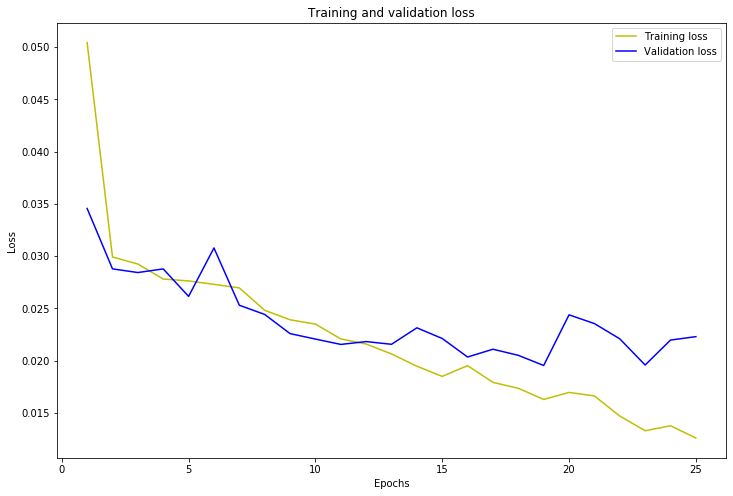

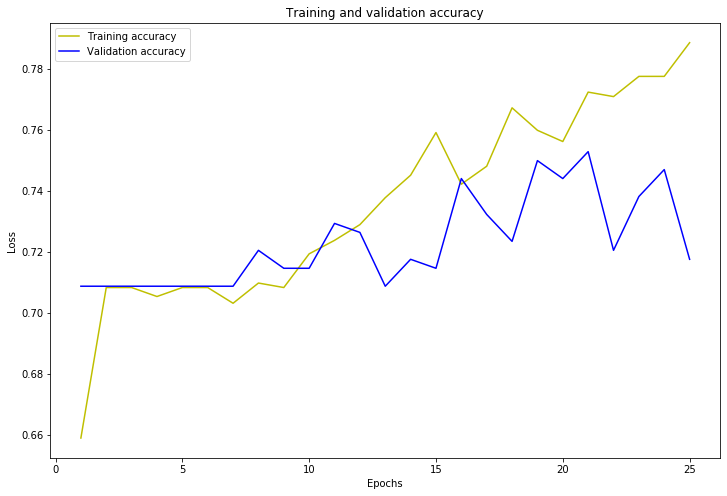

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Вообще говоря, не совсем корректно использовать такую предобученную сеть. Типы "изображений" нашей задачи немного другие. 3 разделенных фильтра не являются RGB-фильтрами, на которых обучалась модель VGG19. На тесте мы получили худший результат, но наша модель оказалась немного переобученной. Лучшее значение функции потерь на валидационной выборке опустилось ниже 0.2, чего наши обычные модели достичь не смогли. Это наталкивает на мысль, что мы не выжали из выборки максимума, и далее необходимо поработать над разработкой более глубокой модели, подходящей под нашу задачу.Ну а пока можно сделать грубый вывод, что мы решили задачу распознавания хрипа и одышки при дыхании человека с точностью 74.3% (первая сверточная сеть).

# Заключение 

На данный момент задача не считается решенной. Три испробованных модели позволили лишь поверхностно взглянуть на поведение обучения. Однако мы не зашли в тупик. Наоборот, есть масса дальнейших действий для улучшения качества предсказания. Вот некоторые из них:

##### 1. Использование аудиофайлов, записанных на микрофон.
Хоть эта часть датасета несколько зашумлена, наша используемая обучающая выборка по размеру почти в два раза меньше количества сегментов, записанных обычным микрофоном. Как вариант, ее можно использовать на конечном этапе решения задачи, когда модель научилась хорошо распознавать хрипы, чтобы улучшить устойчивость модели к переобучению (аналог автоэнкодерам). Еще один способ применения, очистка от посторонних шумов (nn_filter в библиотеке librosa например) и добавление очищенные аудиофайлы к нашей обычной выборке.

##### 2. Аугментация данных

Добавление в датасет синтетически измененные аудиофайлы, для избавления от несбалансированности классов. https://github.com/bmcfee/muda . 

##### 3. Использование более сложной или более специфичной модели.

Как бы мы не изощрялись, но все-таки у нас стоит задача не классфицирования изображений. Возможно стоит обратить внимание на другие виды нейронных сетей или подойти более ответственно к построению сверточной модели.

##### 4. Использовать другое преобразование аудиосигналов

Вся идея решения строилась на Constant-Q гибридном преобразовании. Вполне возможно, что данный подход не совсем верен для respiratory задач. Многие медицинские исследования рекоммендуют использовать обычные вейвлет-преобразования, или быстрые преобразования Фурье. Обработка аудиосигналов - это целая наука, которая в нашем решении не менее важна, чем построение самой модели предсказания.